In [1]:

install.packages("HiddenMarkov")
install.packages("MixtureInf")


library(HiddenMarkov)
library(MixtureInf)




Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Proceso simulado


Datos del proceso simulado

\begin{equation}
P
=\begin{bmatrix}
0.7 & 0.3\\ 
 0.1& 0.9
\end{bmatrix}
\end{equation}

\begin{equation}
\delta = \begin{Bmatrix}
0.7 & 0.3  
\end{Bmatrix}
\end{equation}

\begin{equation}
b_1 = N(4,1)
\end{equation}

\begin{equation}
b_2 = N(0,0.5)
\end{equation}

Simulación:

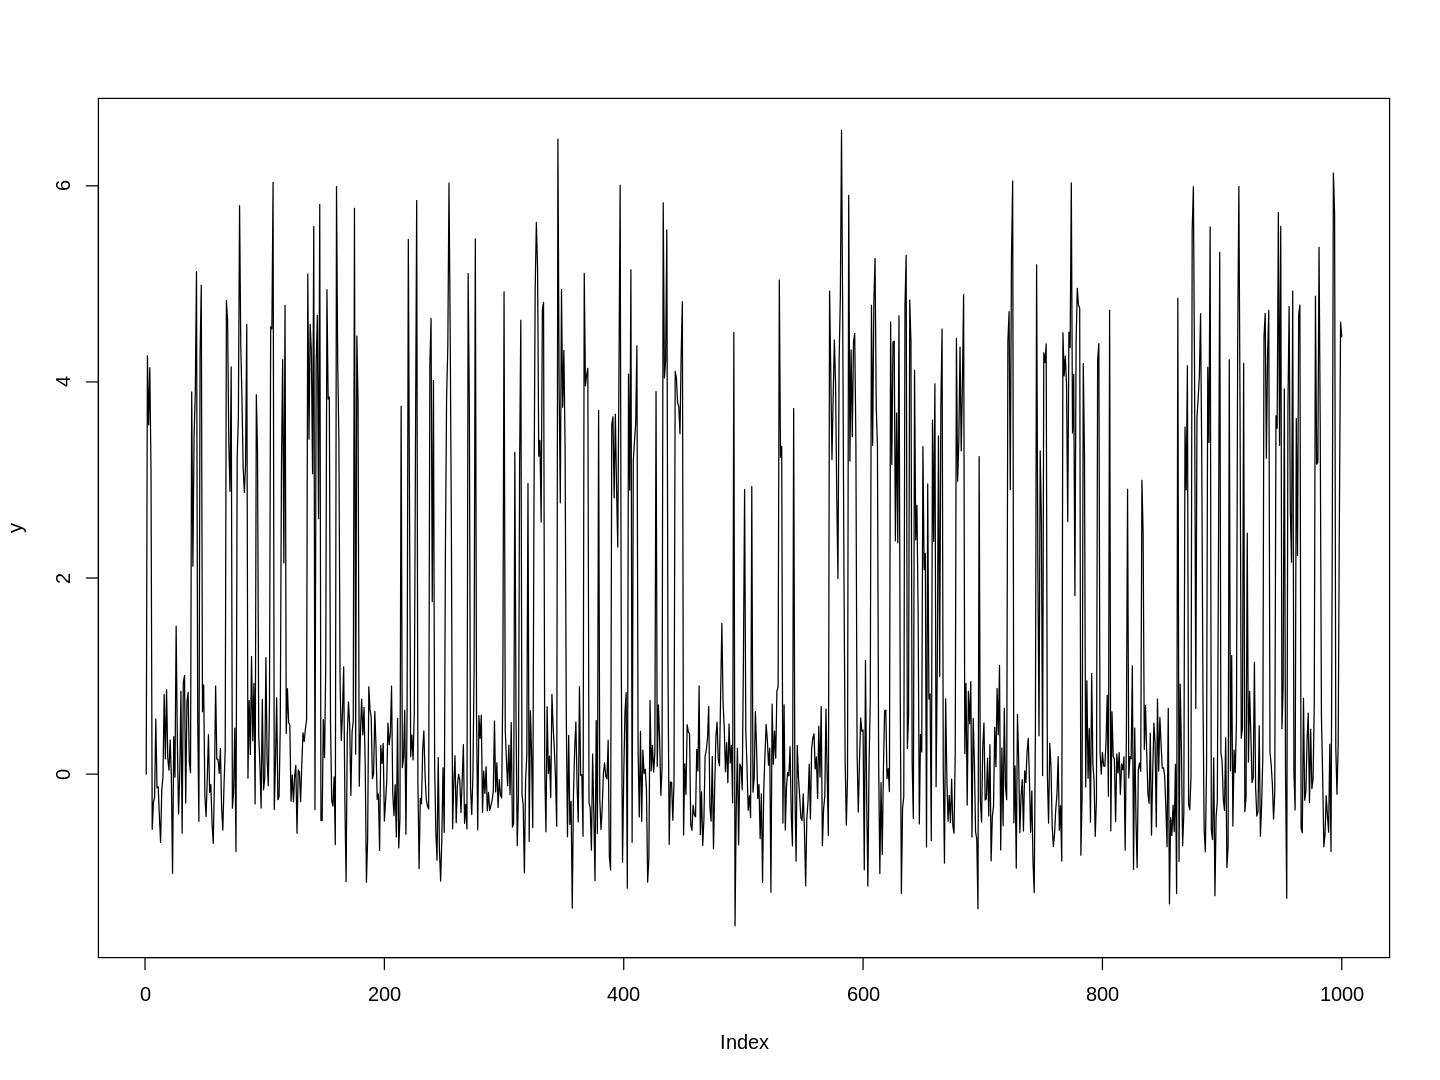

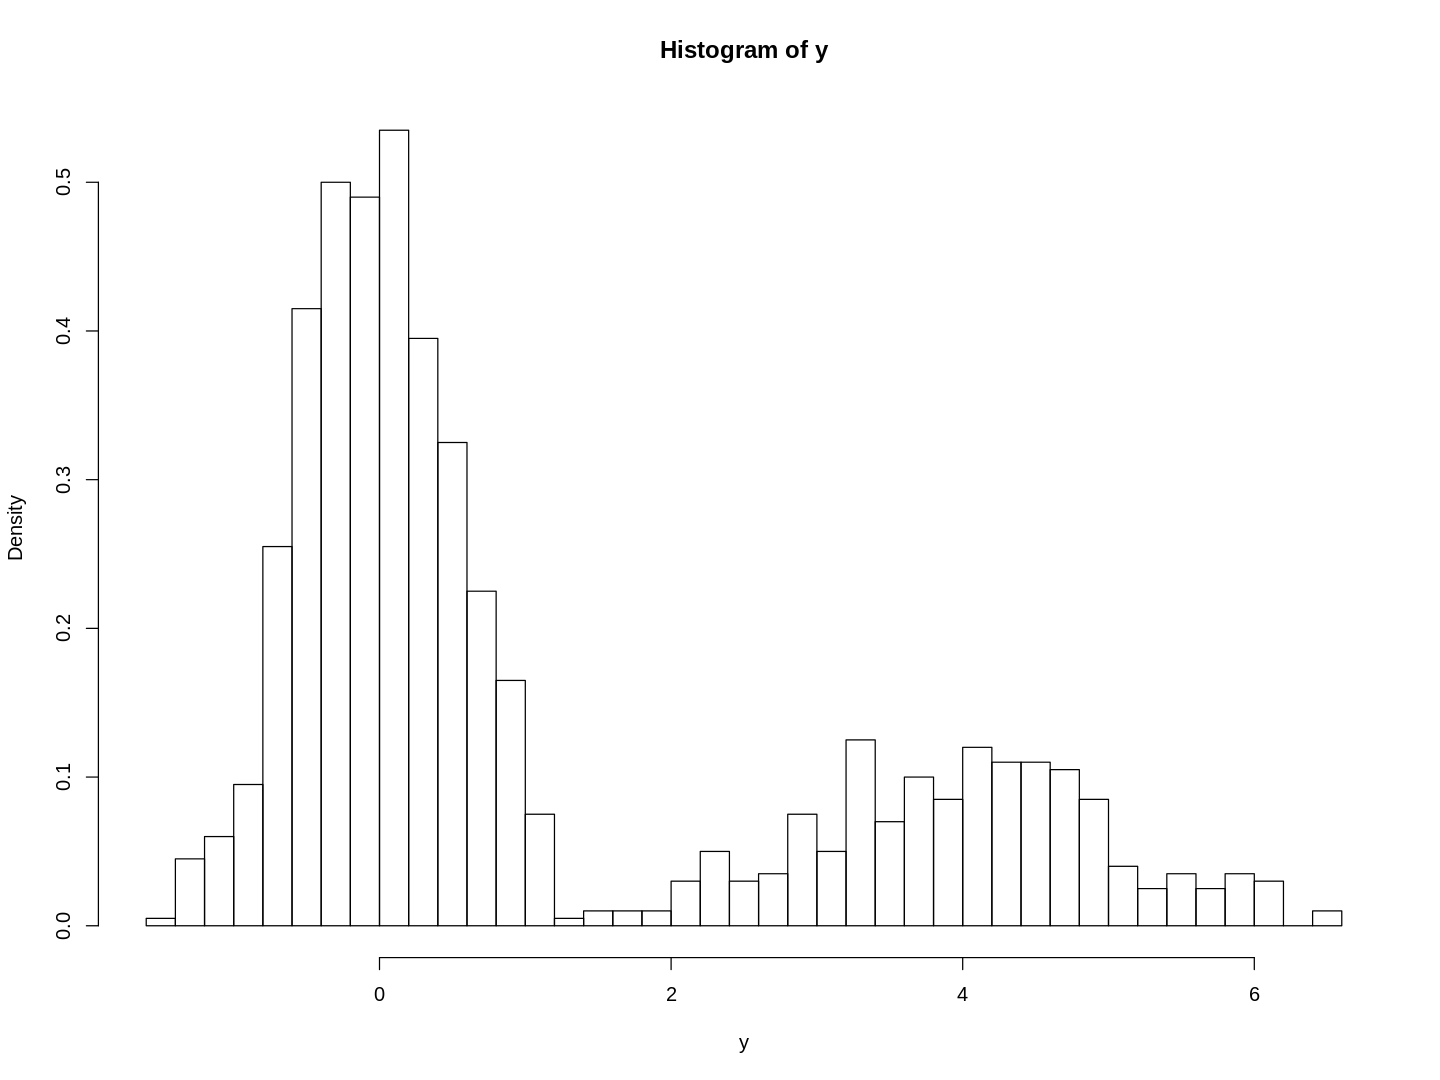

In [4]:
P<- matrix(c(0.7, 0.3, 0.1, 0.9), byrow = TRUE, ncol=2)
b<- matrix(c(4,1,0,0.5), byrow = TRUE, ncol=2 )
delta<-c(0.7,0.3)

N=1000

S=c(1,2)
x=rep(0, times=N)
y=rep(0, times=N)

x[1]<- sample(S, 1, prob = delta)
for (i in 2:N) {
    x[i]<- sample(S, 1, prob = P[x[i-1],])
    y[i]<- rnorm(1, mean = b[x[i],1], sd = b[x[i],2])
}

options(repr.plot.width=12, repr.plot.height=9) #ajusta tamaño de graficas
plot(y, type="l")
h<-hist(y, breaks=30, plot = TRUE, freq = FALSE )

Para estimar el proceso simulado hay que crear un objeto del tipo `dthmm` para comenzar la iteración:

In [5]:
matrizP<- function(viterbi, estados) #viterbi es el resultado de aplicar la funcion Viterbi
{
  estPi <- table(viterbi[-length(viterbi)], viterbi[-1])
  rowtotal <- estPi %*% matrix(1, nrow=estados, ncol=1)
  estPi <- diag(as.vector(1/rowtotal)) %*% estPi
  estPi  
  
}


In [6]:

# Creo primer aproximacion al modelo usando la funcion dthmm
hmm<- dthmm(y, Pi=matrix(c(0.2,0.8,0.4,0.6), nrow=2, byrow=TRUE), delta=c(0.5,0.5), distn="norm", pm= list(mean=c(1, 0), sd=c(0.5, 0.1)))




In [7]:
e<-2
k<-0
while (e>0.000001)
{
  lL_ini<- logLik(hmm)
  viterbi<- Viterbi(hmm)
  MEAN<- c(mean(y[viterbi==1]), mean(y[viterbi==2]))
  SD<- c(sd(y[viterbi==1]), sd(y[viterbi==2]))
  P<- matrizP(viterbi, 2)
  delta<- c(0,0)
  delta[viterbi[1]]<-1
  hmm<- dthmm(y, Pi=P, delta=delta, distn="norm", pm= list(mean=MEAN, sd=SD))
  e<- abs(lL_ini-logLik(hmm))
  k<- k+1 
}

print(paste0("b1: MEAN1=", MEAN[1], " SD1=", SD[1]))
print(paste0("b2: MEAN2=", MEAN[2], " SD2=", SD[2]))
print(P)
print(paste0("k=", k))

[1] "b1: MEAN1=4.01381638516201 SD1=1.00566061122574"
[1] "b2: MEAN2=-0.0153146828512844 SD2=0.524316453271941"
      
               1         2
  [1,] 0.7096774 0.2903226
  [2,] 0.1138889 0.8861111
[1] "k=10"


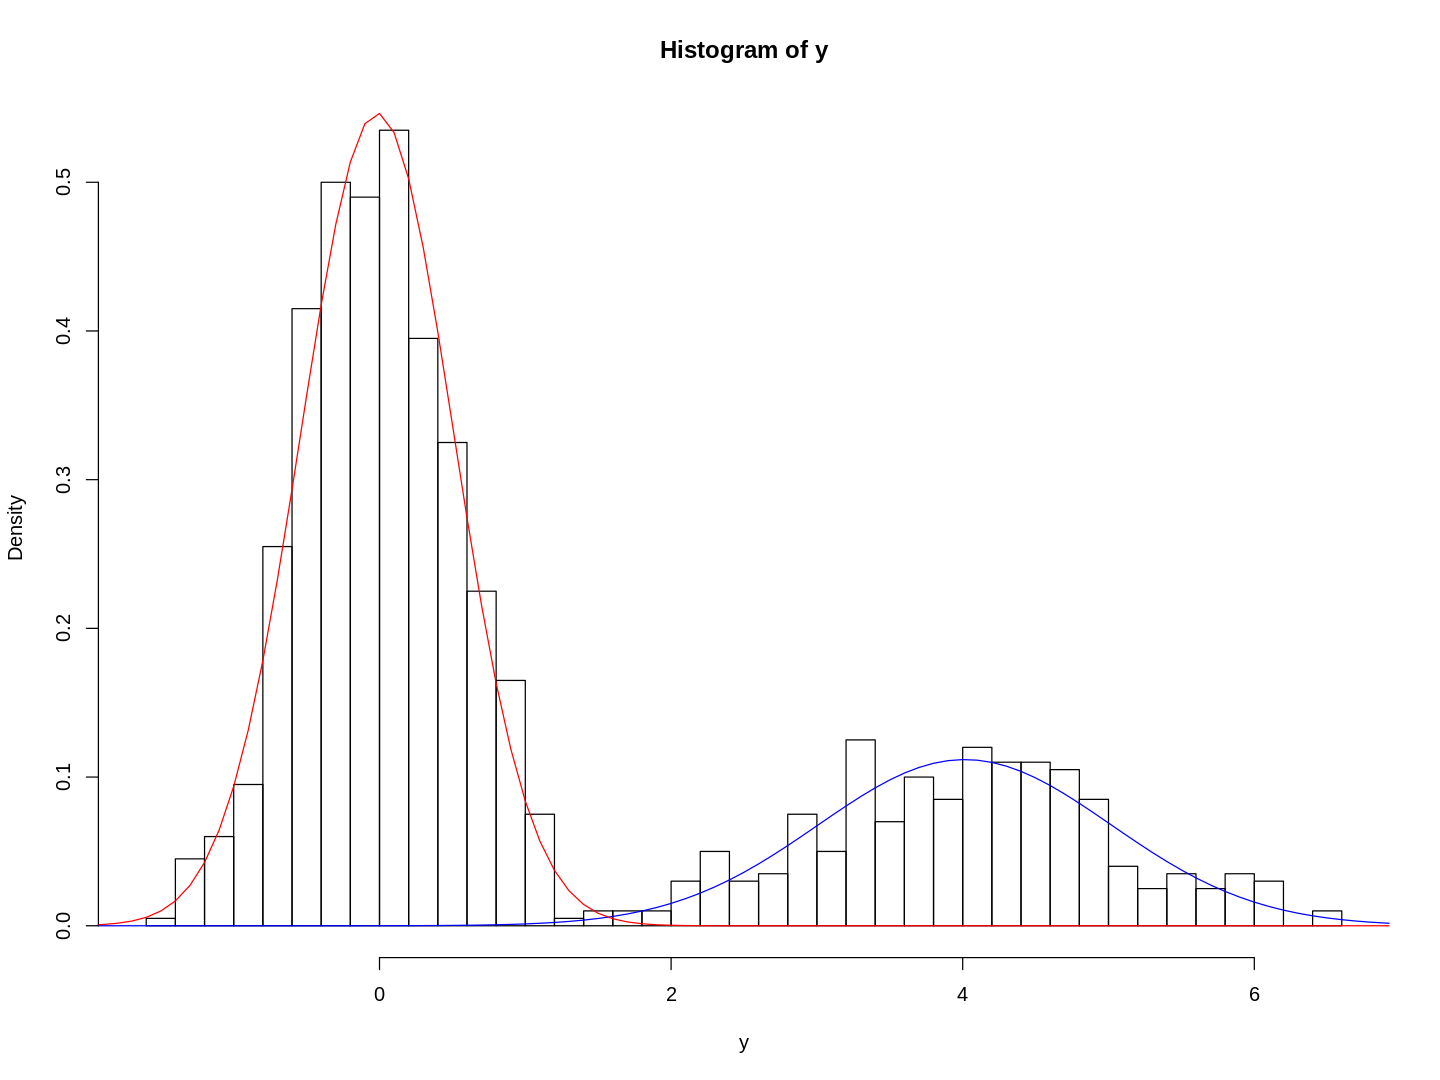

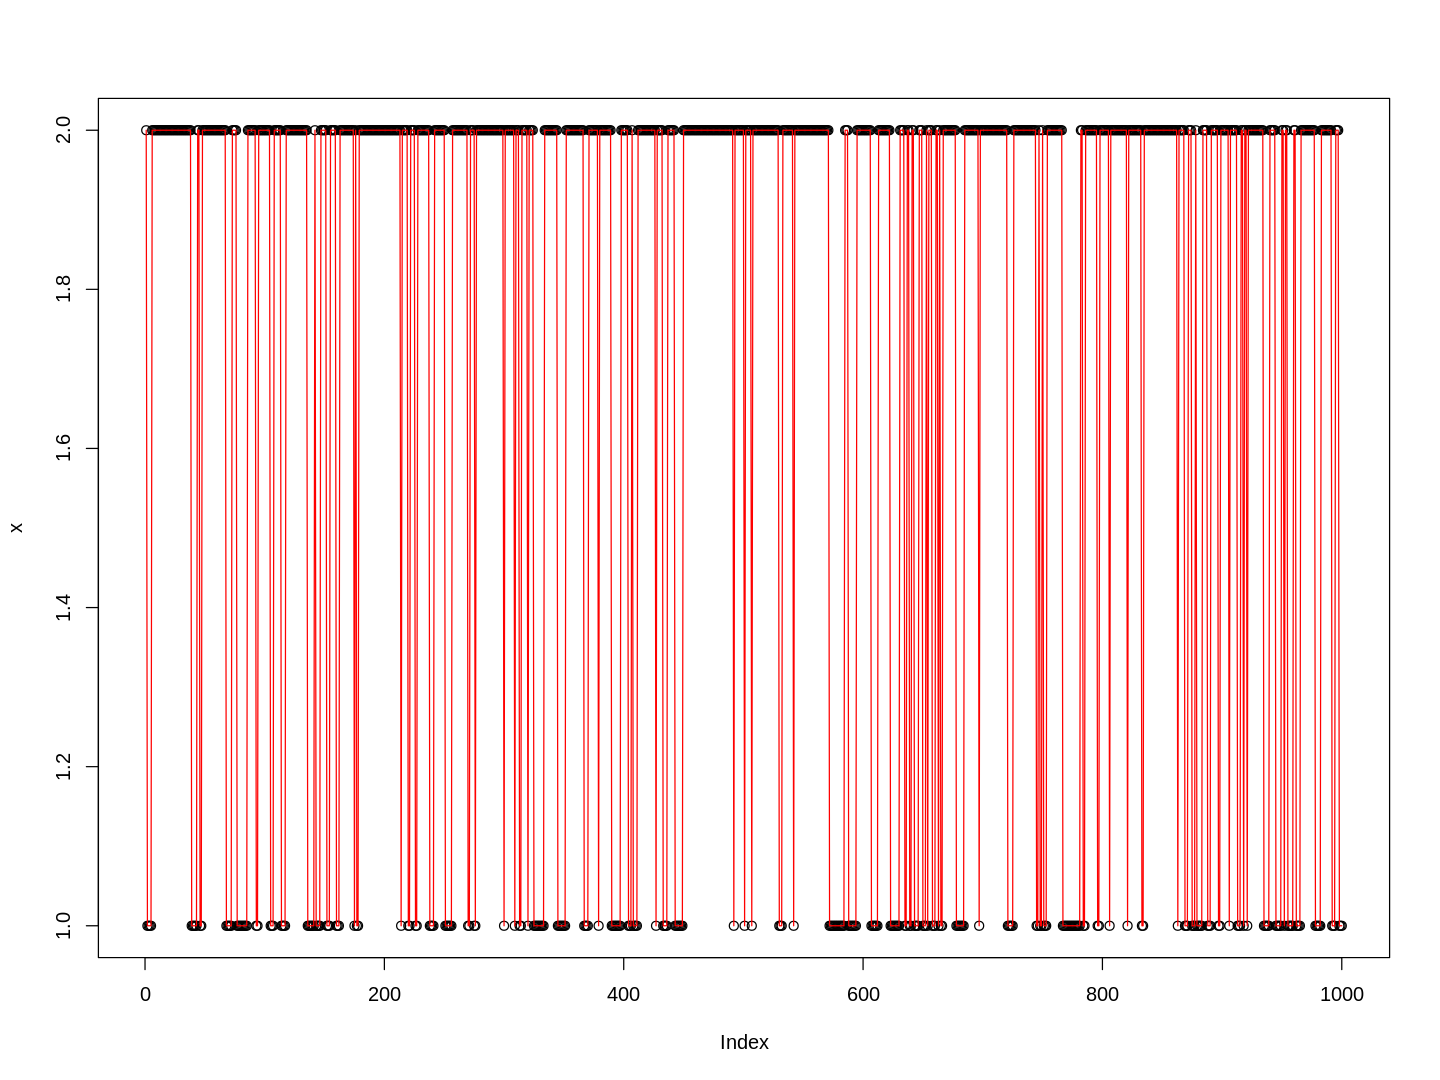

In [8]:
pi1 = P[2,1]/(2 - P[1,1] - P[2,2])
pi2 = 1-pi1
h<-hist(y, breaks=30, plot = TRUE, freq = FALSE )
xvals = seq(-3,7, by=00.1)
G1<-pi1*dnorm(xvals, mean = MEAN[1], sd=SD[1])
lines(xvals, G1, col="blue")
G2<- pi2*dnorm(xvals, mean = MEAN[2], sd=SD[2])
lines(xvals, G2, col="red")

plot(x)
lines(viterbi, col="red")


# Proceso con serie dada: earthquake del paquete MixtureInf

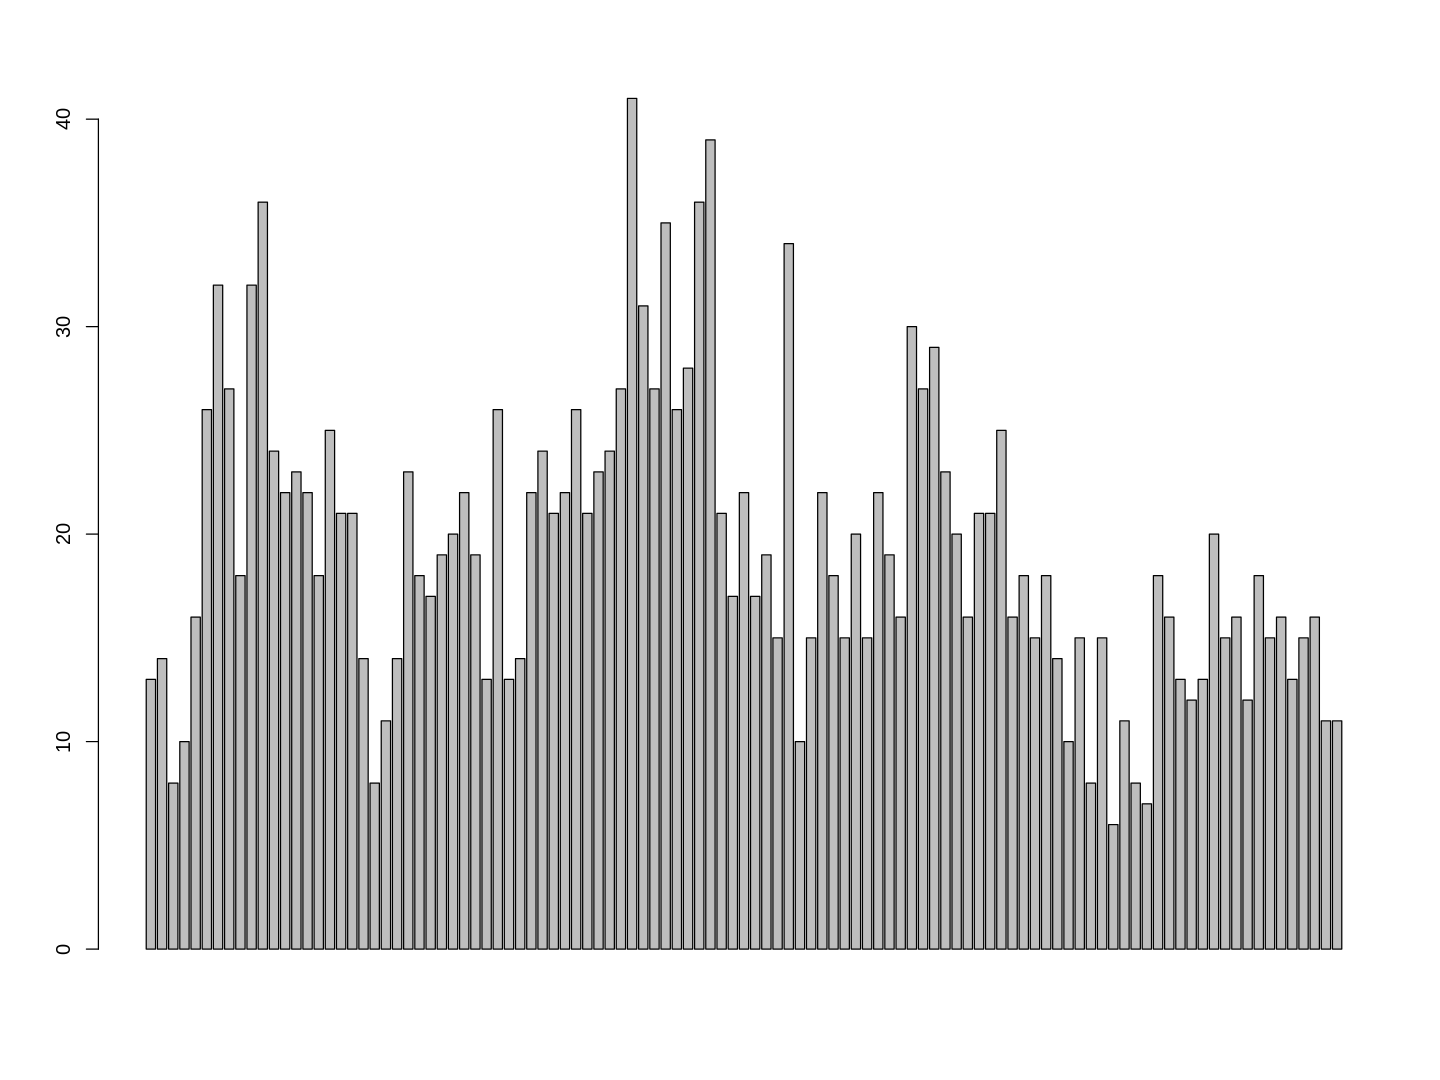

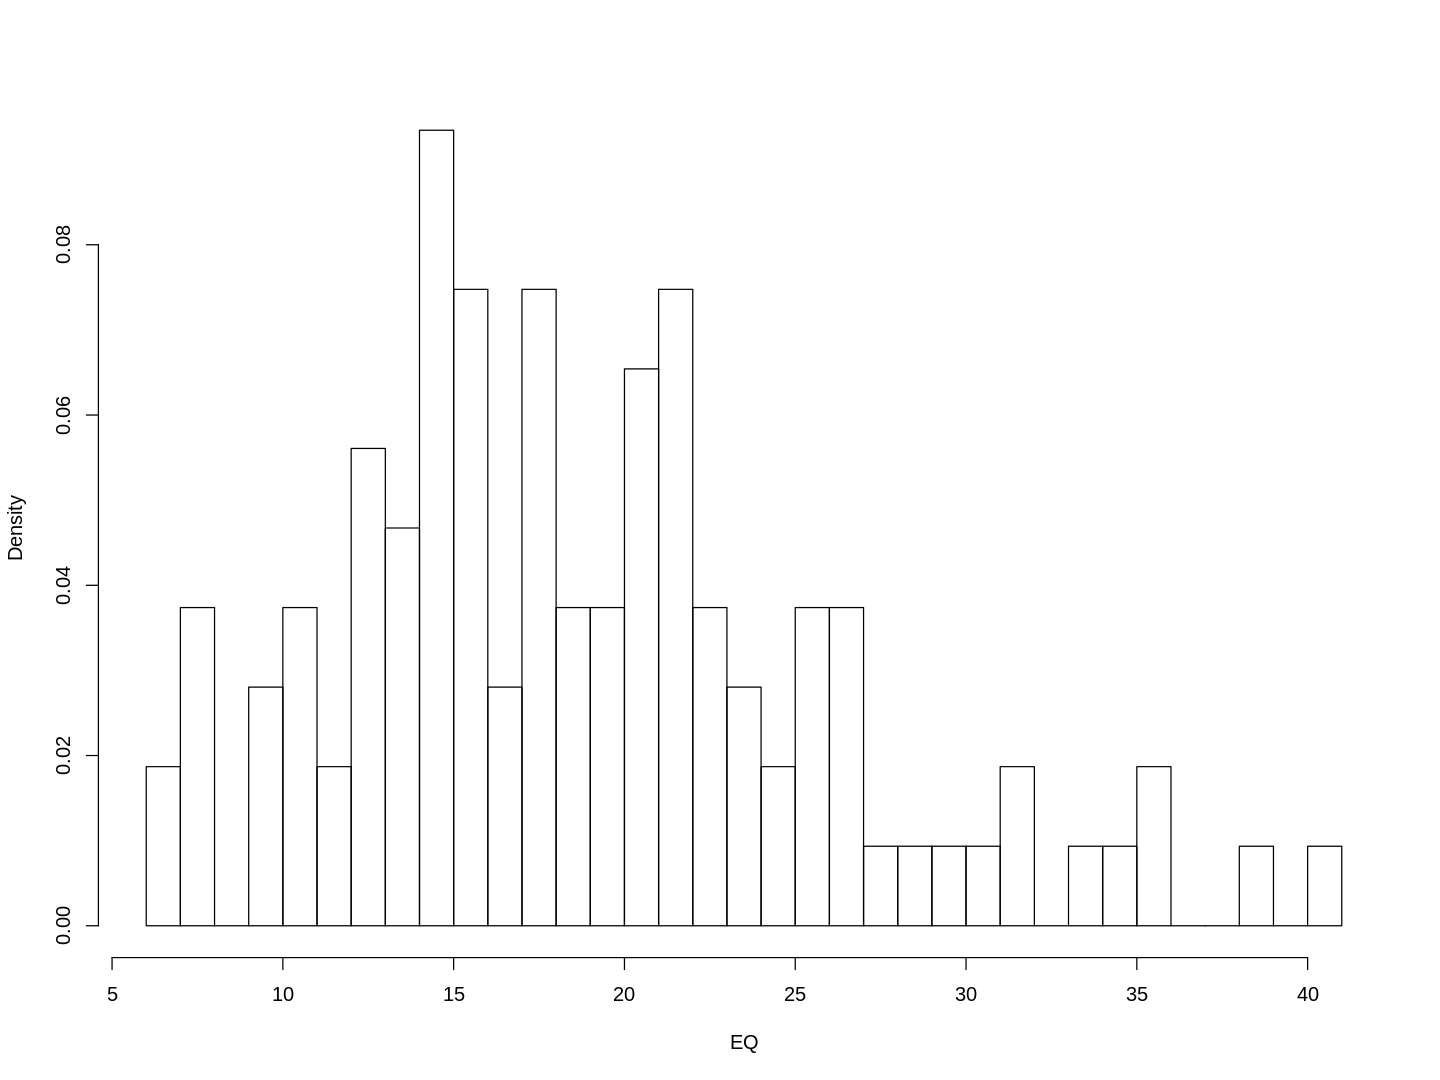

In [9]:
data("earthquake")
EQ<- earthquake$number

barplot(EQ)
hist(EQ, breaks=30, prob=TRUE, main="")
 

Estimación inicial de los parámetros:

In [10]:
x_ini<- ifelse(EQ<=20, 1, 2)

lambda1<- mean(EQ[x_ini==1])
lambda2<- mean(EQ[x_ini==2])
lambda<- c(lambda1, lambda2)

delta<- c(sum(x_ini==1)/length(x_ini), sum(x_ini==2)/length(x_ini))

P_ini<- matrizP(x_ini,2)


hmm<- dthmm(EQ, Pi=P_ini, delta=delta, distn="pois", pm= list(lambda))




In [11]:
e<-2
k<-0
while (e>0.000001)
{
  lL_ini<- logLik(hmm)
  viterbi<- Viterbi(hmm)
  lambda<- c(mean(EQ[viterbi==1]), mean(EQ[viterbi==2]))
  P<- matrizP(viterbi, 2)
  delta<- c(0,0)
  delta[viterbi[1]]<-1
  hmm<- dthmm(EQ, Pi=P, delta=delta, distn="pois", pm= list(lambda))
  e<- abs(lL_ini-logLik(hmm))
  k<- k+1 
}

print(paste0("lambda1=",mean(EQ[viterbi==1])))
print(paste0("lambda2=",mean(EQ[viterbi==2])))
print(P)
k

[1] "lambda1=15.1538461538462"
[1] "lambda2=25.8809523809524"
      
               1         2
  [1,] 0.9375000 0.0625000
  [2,] 0.0952381 0.9047619


[1] 3

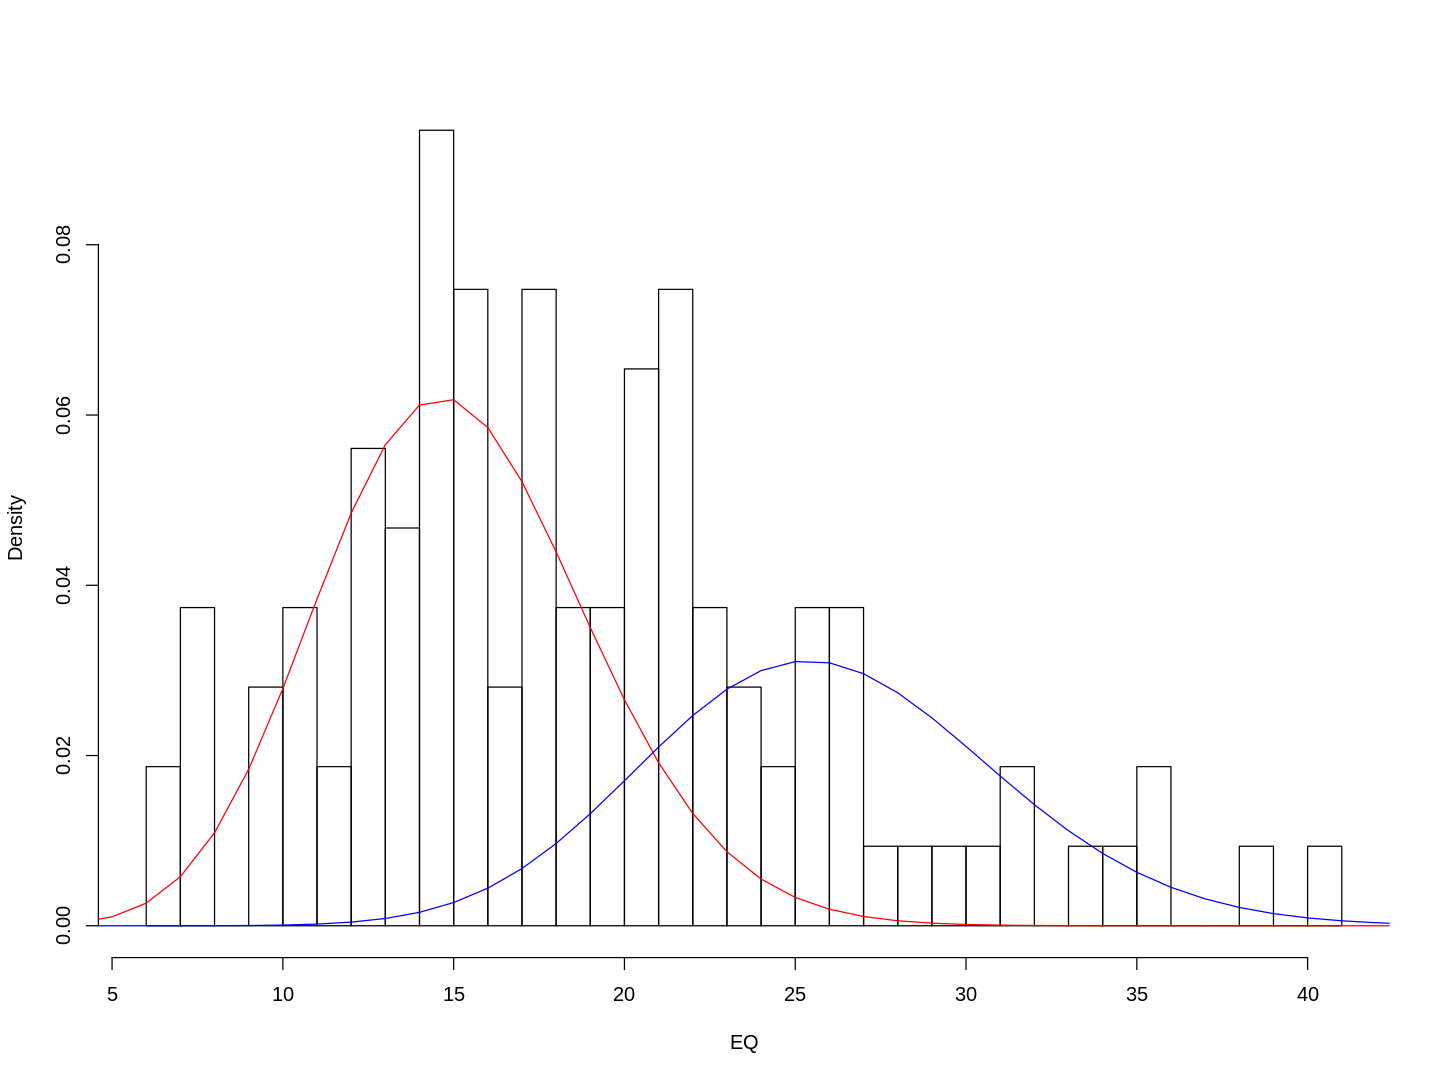

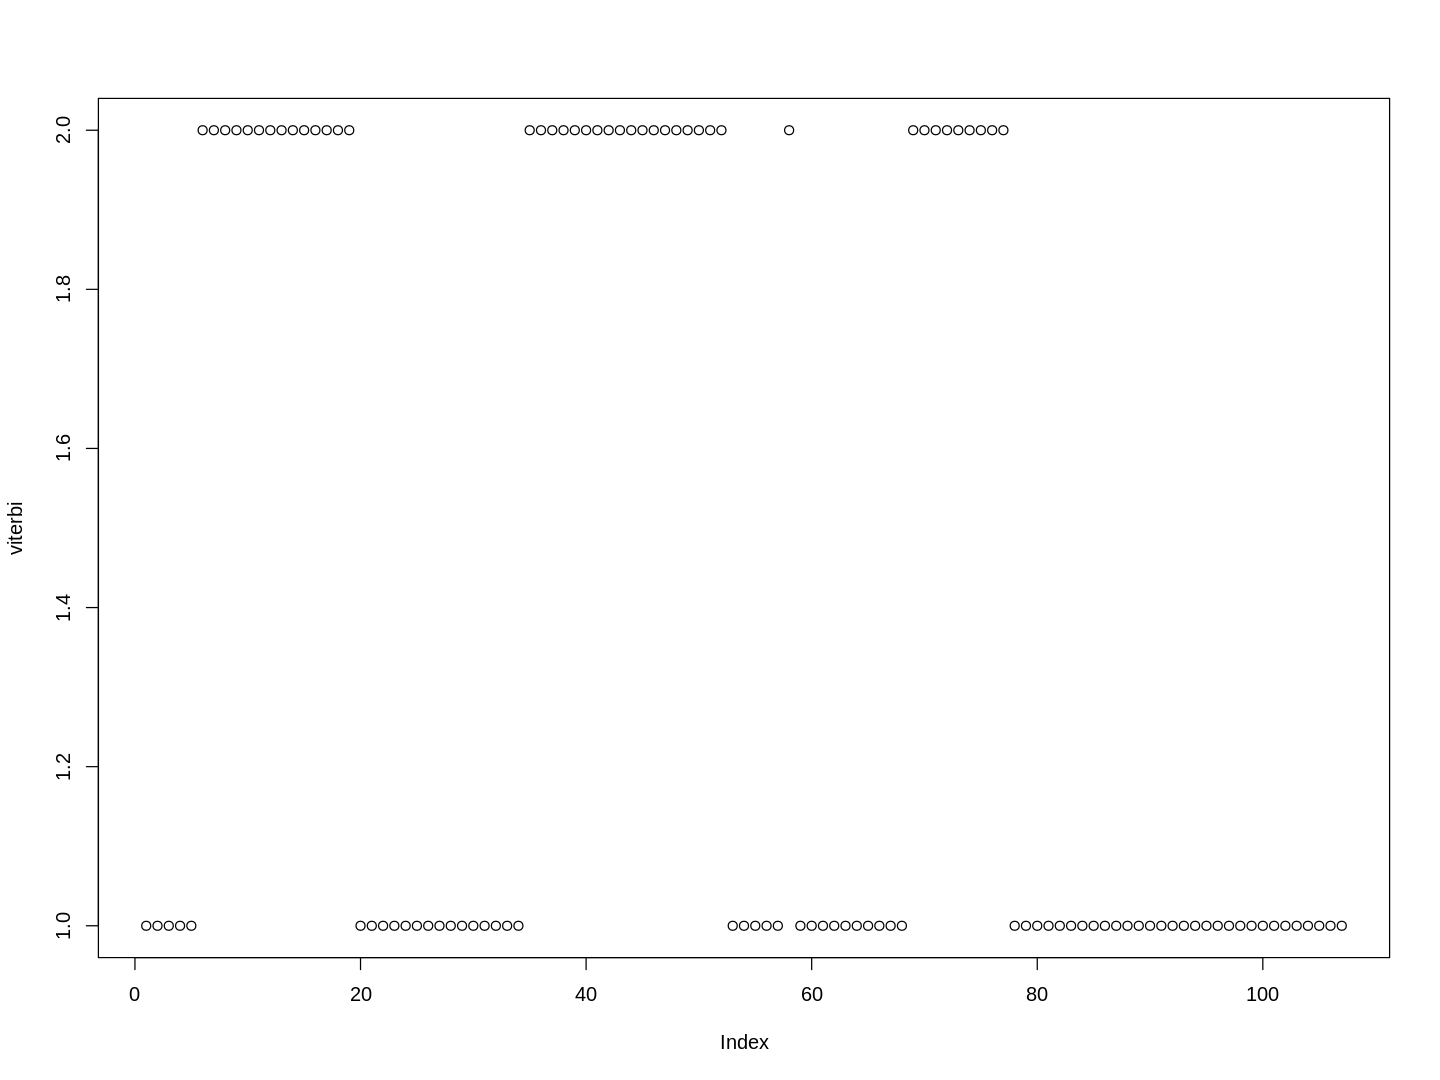

In [12]:
#Estos valores los uso para escalar 
pi1 = P[2,1]/(2 - P[1,1] - P[2,2])
pi2 = 1-pi1


hist(EQ, breaks=30, prob=TRUE, main="")
xvals = seq(1,45)
pois1<- pi1*dpois(xvals, lambda[1])
lines(xvals, pois1, col="red")
pois2<- pi2*dpois(xvals,lambda[2])
lines(xvals, pois2, col="blue")

plot(viterbi)